In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from keras.regularizers import L2
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd

from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
from sklearn.metrics import precision_score, recall_score,f1_score

In [ ]:
def dataprep():
    # Paso 1: Cargar los datos.
    df = pd.read_csv('bank.csv')

    # Paso 2: Definir las columnas categóricas.
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

    # Convertir la columna 'deposit' a binaria
    df['deposit'] = pd.Categorical(df['deposit']).codes

    # Paso 3: Codificar las columnas categóricas con get_dummies
    df = pd.get_dummies(df, columns=categorical_cols)

    # Paso 4: Dividir los datos en características (X) y etiquetas (y), y luego en conjuntos de entrenamiento y evaluación.
    X = df.drop('deposit', axis=1)
    y = df['deposit']

    X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, stratify=y_valtest, random_state=42)

    # Paso 5: Normalizar los datos de entrenamiento y aplicar la misma transformación a los datos de prueba.
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_test, y_test, X_val, y_val 


In [ ]:
def plot_training_validation_loss(lambda_values, softmax_losses, sigmoid_losses, title):
  """
  Gráficos para análisis preliminar de la función de activación de la capa final.
  """
  plt.figure(figsize=(10, 8))

  plt.plot(lambda_values, softmax_losses['train'], label='Softmax Training Loss')
  plt.plot(lambda_values, softmax_losses['validation'], label='Softmax Validation Loss')

  plt.plot(lambda_values, sigmoid_losses['train'], label='Sigmoid Training Loss')
  plt.plot(lambda_values, sigmoid_losses['validation'], label='Sigmoid Validation Loss')

  plt.title(title)
  plt.xlabel('Lambda')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()


In [ ]:
def perc_data(X, y, porcentaje):
  """
  Obtener el porcentaje de unos datos. Se usa para dividir los datos de entrenamiento.
  """
  ntrain = porcentaje * X.shape[0]
  X = X[int(ntrain):]
  y = y[int(ntrain):]
  return X, y

In [ ]:
def red_neuronal_softmax(perc, layer1, layer2, i):
  """
  Red neuronal regularizada que usa softmax de dps neurona para hacer clasificación binaria.
  """
  X_train, y_train, X_test, y_test, X_val, y_val = dataprep()
  
  model = Sequential([
      Dense(units=layer1, activation='relu', kernel_regularizer=l2(i)),
      Dense(units=layer2, activation='relu', kernel_regularizer=l2(i)),
      Dense(units=2, activation='softmax')
  ])

  model.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(from_logits=False))

  if perc < 1:
      X_train, y_train = perc_data(X_train, y_train, perc)

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  model.fit(X_train, y_train, epochs=1000, verbose=0, callbacks=[es], validation_data=(X_val, y_val))

  y_pred_train = np.argmax(model.predict(X_train, verbose=0), axis=1)
  train_loss = np.mean(y_pred_train != y_train)

  y_pred_val = np.argmax(model.predict(X_val, verbose=0), axis=1)
  val_loss = np.mean(y_pred_val != y_val)

  y_pred_test = np.argmax(model.predict(X_test, verbose=0), axis=1)
  test_loss = np.mean(y_pred_test != y_test)

  return train_loss, val_loss, test_loss


In [ ]:
def red_neuronal_sigmoid(perc, layer1, layer2, i):
  """
  Red neuronal regularizada que usa sigmoide de una neurona para hacer clasificación binaria.
  """
  X_train, y_train, X_test, y_test, X_val, y_val = dataprep()

  model = Sequential([
      Dense(units=layer1, activation='relu', kernel_regularizer=l2(i)),
      Dense(units=layer2, activation='relu', kernel_regularizer=l2(i)),
      Dense(units=1, activation='sigmoid')
  ])

  model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(from_logits=False))

  if perc < 1:
      X_train, y_train = perc_data(X_train, y_train, perc)

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) # se usa earling stop para hacer más rápida la simulación

  model.fit(X_train, y_train, epochs=1000, verbose=0, callbacks=[es], validation_data=(X_val, y_val))

  y_pred_train = (model.predict(X_train, verbose=0) > 0.5).astype("int32")
  train_loss = np.mean(y_pred_train.flatten() != y_train)

  y_pred_val = (model.predict(X_val, verbose=0) > 0.5).astype("int32")
  val_loss = np.mean(y_pred_val.flatten() != y_val)

  y_pred_test = (model.predict(X_test, verbose=0) > 0.5).astype("int32")
  test_loss = np.mean(y_pred_test.flatten() != y_test)

  return train_loss, val_loss, test_loss


Epoch 34: early stopping
Modelo Softmax: con una lambda:  0.0 Training Loss:  0.04897715394952964  - Validation Loss:  0.5224014336917563
Epoch 21: early stopping
Modelo Sigmoid: con una lambda:  0.0 Training Loss:  0.07809466925489025  - Validation Loss:  0.4910394265232975
Epoch 80: early stopping
Modelo Softmax: con una lambda:  0.011111111111111112 Training Loss:  0.11109451993429895  - Validation Loss:  0.42562724014336917
Epoch 49: early stopping
Modelo Sigmoid: con una lambda:  0.011111111111111112 Training Loss:  0.12229356428251456  - Validation Loss:  0.4668458781362007
Modelo Softmax: con una lambda:  0.022222222222222223 Training Loss:  0.12617589965656265  - Validation Loss:  0.4789426523297491
Epoch 34: early stopping
Modelo Sigmoid: con una lambda:  0.022222222222222223 Training Loss:  0.13797222637001644  - Validation Loss:  0.5255376344086021
Epoch 78: early stopping
Modelo Softmax: con una lambda:  0.03333333333333333 Training Loss:  0.1303568762132298  - Validation L

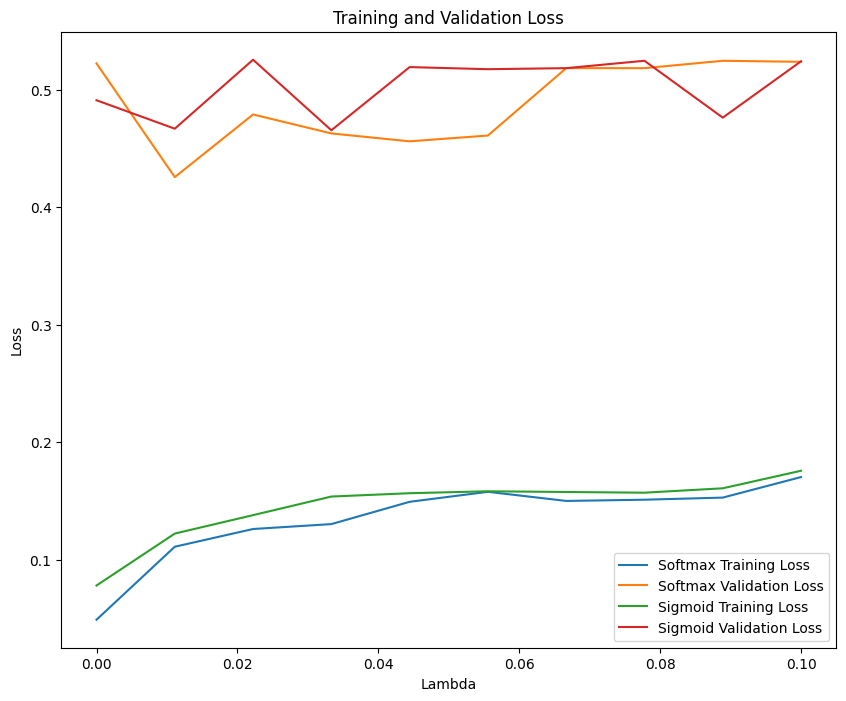

In [ ]:
lambdaa = np.linspace(0, 0.1, 10)
softmax_losses = {'train': [], 'validation': []}
sigmoid_losses = {'train': [], 'validation': []}
# Se compila dos veces este código, primero para lambda hasta 0.1 y después hasta lambda de 0.5
for i in lambdaa:
  train_loss, val_loss, _ = red_neuronal_softmax(1, 64, 32, i)
  softmax_losses['train'].append(train_loss)
  softmax_losses['validation'].append(val_loss)
  print("Modelo Softmax: con una lambda: ", i, "Training Loss: ", train_loss, " - Validation Loss: ", val_loss)
  train_loss, val_loss, _ = red_neuronal_sigmoid(1, 64, 32, i)
  sigmoid_losses['train'].append(train_loss)
  sigmoid_losses['validation'].append(val_loss)
  print("Modelo Sigmoid: con una lambda: ", i, "Training Loss: ", train_loss, " - Validation Loss: ", val_loss)
plot_training_validation_loss(lambdaa, softmax_losses, sigmoid_losses, 'Training and Validation Loss')


Epoch 32: early stopping
Modelo Softmax: con una lambda:  0.0 Training Loss:  0.052411527549649096  - Validation Loss:  0.5497311827956989
Epoch 18: early stopping
Modelo Sigmoid: con una lambda:  0.0 Training Loss:  0.08481409586381962  - Validation Loss:  0.5044802867383512
Epoch 48: early stopping
Modelo Softmax: con una lambda:  0.03571428571428571 Training Loss:  0.13797222637001644  - Validation Loss:  0.5210573476702509
Epoch 30: early stopping
Modelo Sigmoid: con una lambda:  0.03571428571428571 Training Loss:  0.15126175899656563  - Validation Loss:  0.521505376344086
Epoch 54: early stopping
Modelo Softmax: con una lambda:  0.07142857142857142 Training Loss:  0.1569359414663282  - Validation Loss:  0.5134408602150538
Epoch 59: early stopping
Modelo Sigmoid: con una lambda:  0.07142857142857142 Training Loss:  0.15604001791847097  - Validation Loss:  0.5237455197132617
Epoch 99: early stopping
Modelo Softmax: con una lambda:  0.10714285714285714 Training Loss:  0.1576825444228

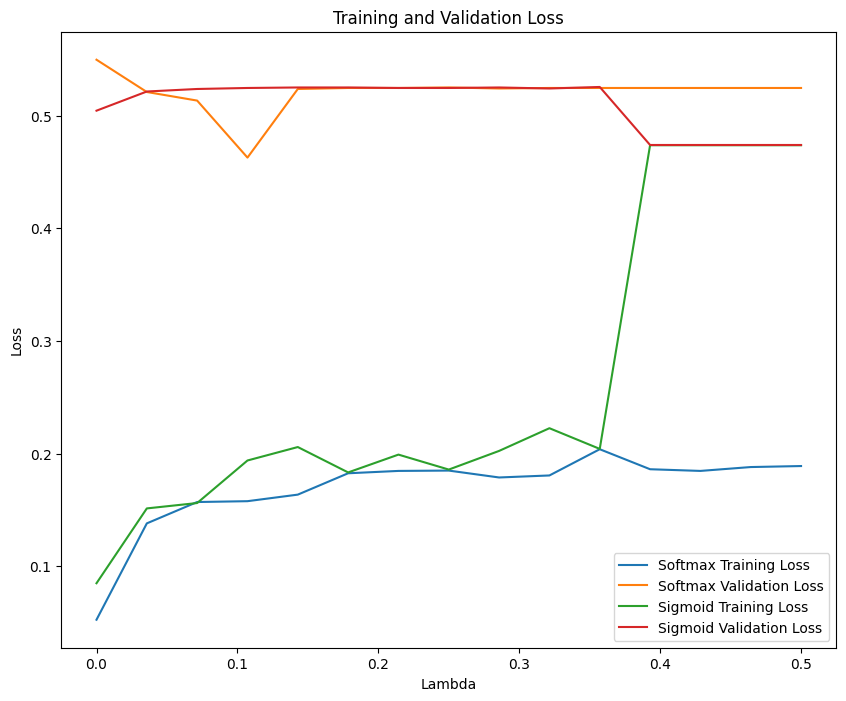

In [ ]:
lambdaa = np.linspace(0, 0.5, 15)
softmax_losses = {'train': [], 'validation': []}
sigmoid_losses = {'train': [], 'validation': []}

for i in lambdaa:
  train_loss, val_loss, _ = red_neuronal_softmax(1, 64, 32, i)
  softmax_losses['train'].append(train_loss)
  softmax_losses['validation'].append(val_loss)
  print("Modelo Softmax: con una lambda: ", i, "Training Loss: ", train_loss, " - Validation Loss: ", val_loss)
  train_loss, val_loss, _ = red_neuronal_sigmoid(1, 64, 32, i)
  sigmoid_losses['train'].append(train_loss)
  sigmoid_losses['validation'].append(val_loss)
  print("Modelo Sigmoid: con una lambda: ", i, "Training Loss: ", train_loss, " - Validation Loss: ", val_loss)
plot_training_validation_loss(lambdaa, softmax_losses, sigmoid_losses, 'Training and Validation Loss')


Probamos inicialmente con un lambda hasta 0.1, como vemos que no convergen los errrores de validación y entrenamiento, probaremos con un parámetro de regularización mayor.

En este primer análisis preliminar vamos a comparar dos funciones de activación en la capa final de la red neuronal: La función sigmoide y la softmax. 
Desde un apartado teórico, se ha explicado que para la clasificación binaria es conveniente utilizar en la última capa de la red neuronal la función sigmoide sin una explicación muy clara, sin embargo, en nuestro proyecto hemos decidió comprobar de forma empírica si la función sigmode es mejor frente a la softmax, ya que esta última en general se utiliza para clasificación multiclase mediante asignación de probabilidades a cada una de las clases, pero como la clasificación binaria es un subconjunto de la clasificación multiclase, también podemos utilizar.

Lo que se ha hecho es comprobar cuál de las dos funciones de activación predice mejor el resultado de entrenamiento y validación. Para ello se ha creado una red neuronal de 64 neuronas en la primera capa y 32 neuronas en la segunda capa y parametrizado las lambdas y el número de casos de entrenamiento. Se ha ejecutado de forma paralela ambas configuraciones y se ha analizado la pérdida obtenida en la predicción tanto en el entrenamiento como en la validación. Se llega a la conclusión de forma empírica que la función de activación softmax genera mejores resultados frente a la sigmoide para nuestros datos de entrenamiento, cosa que no concuerda con la teoría explicada. Igualmente, como los resultados son similares, trabajaremos con la función de activación sigmoide de acuerdo a la teoría ya que tenemos clasificación bianria.

A partir de ahora, utilizaremos la función sigmoide con función de activación en la última capa con la función de pérdidas BinaryCrossentropy en lugar de SparseCategoricalCrossentropy que usa softmax.


In [ ]:
def print_curvaAprendizaje(trainsize, train_losses, val_losses, title, test_losses=0):
  plt.plot(trainsize, train_losses, label='Training loss')
  plt.plot(trainsize, val_losses, label='Validation loss')
  #plt.plot(trainsize, test_losses, label='Test loss')

  plt.xlabel('Train size')
  plt.ylabel('Loss')
  plt.legend()
  plt.title(title)
  plt.show()


Además, esta observación de distintas lambdas para el error de validación y entrenamiento permite apreciar que para la función sigmoide, la convergencia entre el error de validación y el error de entrenamiento se da para un parámetro de regularización (lambda) de en torno a un 0.35 para una red de 64 y 32 neuronas. Debido a esto, se buscará el valor óptimo de lambda por debajo de este número. Recordemos que si la diferencia entre el error de validación y entrenamiento es mínima para un parámetro de regularización elevado(como para un lambda de 0.4) habrá mucho sesgo. Esto significa que el peso de los parámetros será bajo y se produce un subajuste, o underfiting en inglés. Por el contrario, si tenemos un lambda muy bajo, el error de entrenamiento es mínimo porque se le da mucha peso a los parámetros. Esto implica que la varianza será muy grande y el modelo este sobreajustando, u overfiting.

Por lo tanto, el objetivo de la siguiente parte de esta implementación es buscar un parámetro de regularización óptimo que no produzca ni sobreajuste ni subajuste. Para esto, se buscará dicho parámetro entre 0.05 y 0.27 aproximadamente.

Epoch 44: early stopping
Epoch 45: early stopping
Epoch 39: early stopping
Epoch 32: early stopping
Epoch 36: early stopping
Epoch 40: early stopping
Epoch 54: early stopping
Epoch 34: early stopping
Epoch 31: early stopping
Epoch 11: early stopping
Epoch 36: early stopping
Epoch 60: early stopping
Epoch 43: early stopping
Epoch 45: early stopping
Epoch 85: early stopping
Epoch 85: early stopping
Epoch 52: early stopping
Epoch 20: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 55: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 12: early stopping


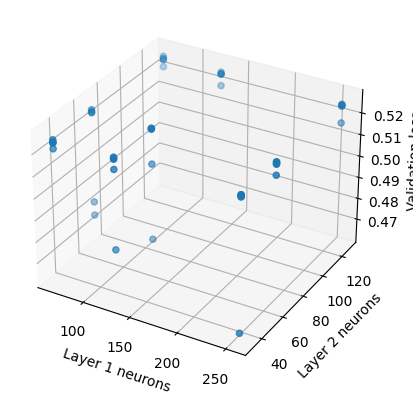

In [ ]:
from sklearn.model_selection import ParameterGrid

def create_model(layer1=32, layer2=32, i=0.01):
    """
    Esta función crea y devuelve el mejor modelo de red neuronal según los parámetros de entrada (nº de neuronas en las distintas capas y la lambda).
    Se hace en función de la pérdida de validación.
    """
    train_loss, val_loss, _ = red_neuronal_sigmoid(1, layer1, layer2, i)
    return val_loss

# Definimos el espacio de búsqueda para los hiperparámetros: neuronas capa1, neuronas capa2 y i, que es lambda
param_grid = {'layer1': [64, 128, 256], 
              'layer2': [32, 64, 128],
              'i': [0.05, 0.1, 0.15, 0.22, 0.25]}
 
# Creamos el objeto de GridSearch
grid = ParameterGrid(param_grid)

# Buscamos los mejores parámetros
best_score = np.inf
best_params = None
scores = []
layer1_values = []
layer2_values = []
for params in grid:
    score = create_model(**params)
    scores.append(score)
    layer1_values.append(params['layer1'])
    layer2_values.append(params['layer2'])
    if score < best_score:
        best_score = score
        best_params = params

print("Best score: %f using %s" % (best_score, best_params))
r
from mpl_toolkits.mplot3d import Axes3D

# Crea la gráfica 3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(layer1_values, layer2_values, scores)
ax.set_xlabel('Layer 1 neurons')
ax.set_ylabel('Layer 2 neurons')
ax.set_zlabel('Validation loss')

plt.show()



En la utilización del parameter grid para optimizar los hiperparámetros: las neuronas de la capa 1 de la capa 2 y la lambda. Los resultados obtenidos son 256 y 32 neuronas en las capas, y un parámetro de regularización lambda de 0.05. Por lo tanto, de ahora en adelante usaremos esta configuración en la red. En la evaluación observaremos si esta configuración es buena para los datos de test y también lo veremos en comparación con otros algoritmos desarrollados.


La documentación utilizada para usar el parametergrid es la siguiente:

https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html


Epoch 46: early stopping
Epoch 35: early stopping
Epoch 47: early stopping
Epoch 56: early stopping
Epoch 54: early stopping
Epoch 58: early stopping
Epoch 41: early stopping
Epoch 50: early stopping
Epoch 67: early stopping
Epoch 48: early stopping
Epoch 45: early stopping
Epoch 64: early stopping
Epoch 71: early stopping
Epoch 58: early stopping
Epoch 76: early stopping
Epoch 73: early stopping
Epoch 11: early stopping
Epoch 61: early stopping
Epoch 78: early stopping
Epoch 82: early stopping
Epoch 57: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 12: early stopping
Epoch 45: early stopping


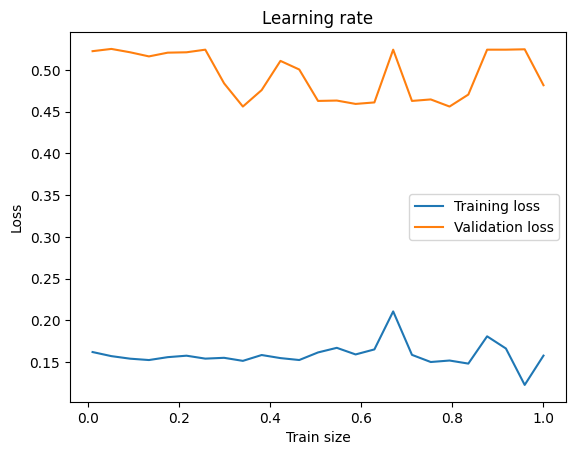

In [ ]:
"""
Entrenamos con distintos porcentaje de datos de entrenamiento entre 1 y 100% con los mejores paramétros obtenidos en la fase anterior (capa1 = 256, capa2 = 32 y lambda = 0.05)
"""
trainsize = np.linspace(0.01, 1, 25)
train_lossesA = []
val_lossesA = []
train_lossesB =[]
val_lossesB = []
for i in trainsize:
  train_loss, val_loss, _ = red_neuronal_sigmoid(i, 256 , 32, 0.05)
  train_lossesA.append(train_loss) 
  val_lossesA.append(val_loss)
print_curvaAprendizaje(trainsize, train_lossesA, val_lossesA, "Learning rate")

En este caso, escogemos el 100% de los datos de entrenamiento. Esto se debe a que se puede observar una tendencia a disminuir la pérdida de validación desde poco antes de 0.9 por lo que tomando el 100% podremos obtener el mejor modelo. En 1 la pérdida de validación disminuye y además podremos entrenar al modelo con más datos.

In [ ]:
def red_neuronal_sigmoidfinal(perc, layer1, layer2, i):
  """
  Red neuronal regularizada que usa sigmoide de una neurona para hacer clasificación binaria.
  """
  X_train, y_train, X_test, y_test, X_val, y_val = dataprep()

  model = Sequential([
      Dense(units=layer1, activation='relu', kernel_regularizer=l2(i)),
      Dense(units=layer2, activation='relu', kernel_regularizer=l2(i)),
      Dense(units=1, activation='sigmoid')
  ])

  model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(from_logits=False))

  if perc < 1:
      X_train, y_train = perc_data(X_train, y_train, perc)

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

  model.fit(X_train, y_train, epochs=1000, verbose=0, callbacks=[es], validation_data=(X_val, y_val))

  y_pred_train = (model.predict(X_train, verbose=0) > 0.5).astype("int32")
  train_loss = np.mean(y_pred_train.flatten() != y_train)

  y_pred_val = (model.predict(X_val, verbose=0) > 0.5).astype("int32")
  val_loss = np.mean(y_pred_val.flatten() != y_val)

  y_pred_test = (model.predict(X_test, verbose=0) > 0.5).astype("int32")
  test_loss = np.mean(y_pred_test.flatten() != y_test)

  return y_pred_test, test_loss


In [ ]:
def plot_precision_recall(precision_test, recall_test):
    plt.figure(figsize=(15, 6))

    # Gráfico para el conjunto de prueba
    plt.subplot(1, 2, 2)
    plt.barh(['Precision', 'Recall'], [precision_test, recall_test], color=['#1f77b4', '#ff7f0e'])
    plt.xlabel('Score')
    plt.title('Test Data')

    plt.tight_layout() 
    plt.show()


Epoch 219: early stopping
Modelo Sigmoid: con una lambda:  0.05  - Test Loss:  0.15181370353784146
El porcentaje de aciertos en los datos de test 0.8481862964621585
Recall y precisión de test:  0.8648393194706995  y  0.8235823582358236
Medida F1 de test:  0.8437067773167358


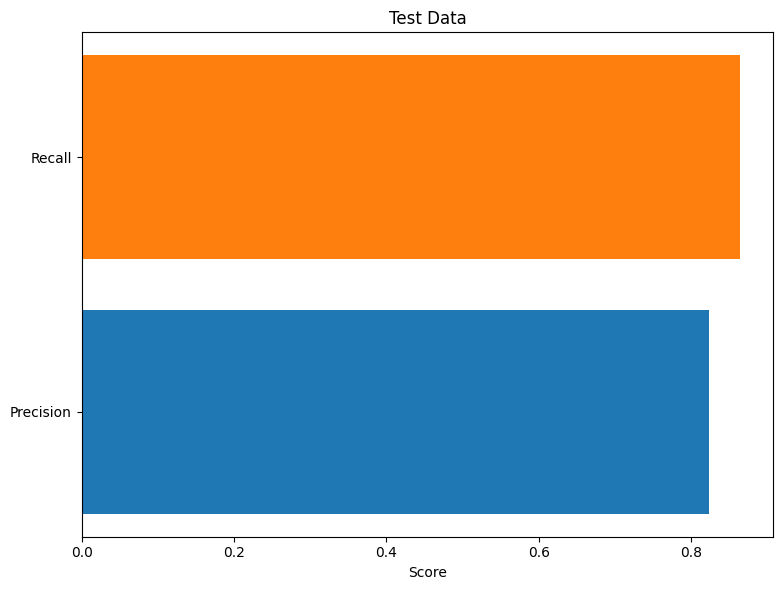

In [ ]:

best_lambda = 0.05
layer1= 256
layer2=32
X_train, y_train, X_test, y_test, X_val, y_val = dataprep()
y_pred, test_loss = red_neuronal_sigmoidfinal(1, layer1, layer2, best_lambda)

print("Modelo Sigmoid: con una lambda: ", best_lambda, " - Test Loss: ", test_loss)

test_accuracy = 1-test_loss
print("El porcentaje de aciertos en los datos de test", test_accuracy)

# Calculamos la precisión, el recall y la F1 en el conjunto de test
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)

print("Recall y precisión de test: ", recall_test, " y ", precision_test)
print("Medida F1 de test: ", f1_test)

# Si tienes una función plot_precision_recall() para graficar precisión y recall
plot_precision_recall(precision_test, recall_test)


Cabe señalar que como los puntos donde apreciamos un menor error de validación son 0.7 y 1, hicimos la comprobación para 0.7 y se obtienen mejores resultados de test para 1. Además, esto refuerza nuestra posición de elegir todos los datos de entrenamiento para entrenar el modelo.

Por lo tanto, podemos estar satisfechos con los resultados obtenidos ya que tiene más accuracy que el resto de modelos. Se ha realizado un buen trabajo con el parametergrid. Es destacable que aumentamos en 30 el earlystop para asegurarnos de que consiga la mejor predicción en la evaluación.

La red neuronal alcanza altos resultados en la precisión y el accuracy.